# Stock Forecasting with LSTM

## Import Libraries

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

## Loading the dataset

In [2]:
import pandas as pd
dataset="dataset/MSFT.csv"

df = pd.read_csv(dataset)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400
...,...,...,...,...,...,...,...
9625,2024-05-22,430.089996,432.410004,427.130005,430.519989,430.519989,18073700
9626,2024-05-23,432.970001,433.600006,425.420013,427.000000,427.000000,17211700
9627,2024-05-24,427.190002,431.059998,424.410004,430.160004,430.160004,11845800
9628,2024-05-28,429.630005,430.820007,426.600006,430.320007,430.320007,15706000


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9630.000000,9630.000000,9630.000000,9630.000000,9630.000000,9.630000e+03
mean,56.732557,57.321285,56.130464,56.747588,51.119855,5.693863e+07
std,86.686061,87.505350,85.824408,86.709196,86.685667,3.814265e+07
min,0.088542,0.092014,0.088542,0.090278,0.055765,2.304000e+06
25%,5.666016,5.728516,5.578125,5.656250,3.493895,3.227405e+07
50%,27.280001,27.535626,27.040001,27.293438,19.145755,5.006600e+07
75%,46.373750,46.887500,45.833125,46.355938,37.760951,7.092580e+07
max,432.970001,433.600006,427.160004,430.519989,430.519989,1.031789e+09


## Data Preparation

In [5]:
# Missing values for every column
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
df = df[['Date', 'Close']]
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9625,2024-05-22,430.519989
9626,2024-05-23,427.000000
9627,2024-05-24,430.160004
9628,2024-05-28,430.320007


In [9]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [10]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9625   2024-05-22
9626   2024-05-23
9627   2024-05-24
9628   2024-05-28
9629   2024-05-29
Name: Date, Length: 9630, dtype: datetime64[ns]

In [13]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-05-22,430.519989
2024-05-23,427.000000
2024-05-24,430.160004


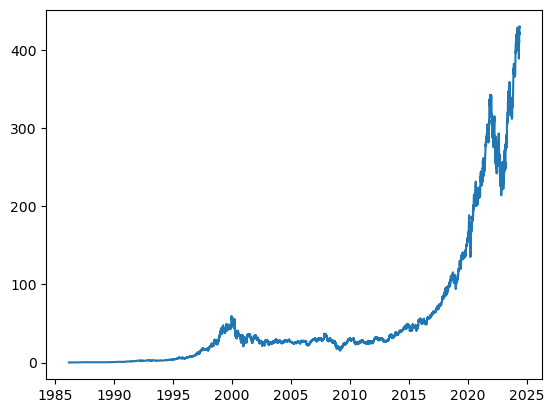

In [14]:
plt.plot(df.index, df['Close'])

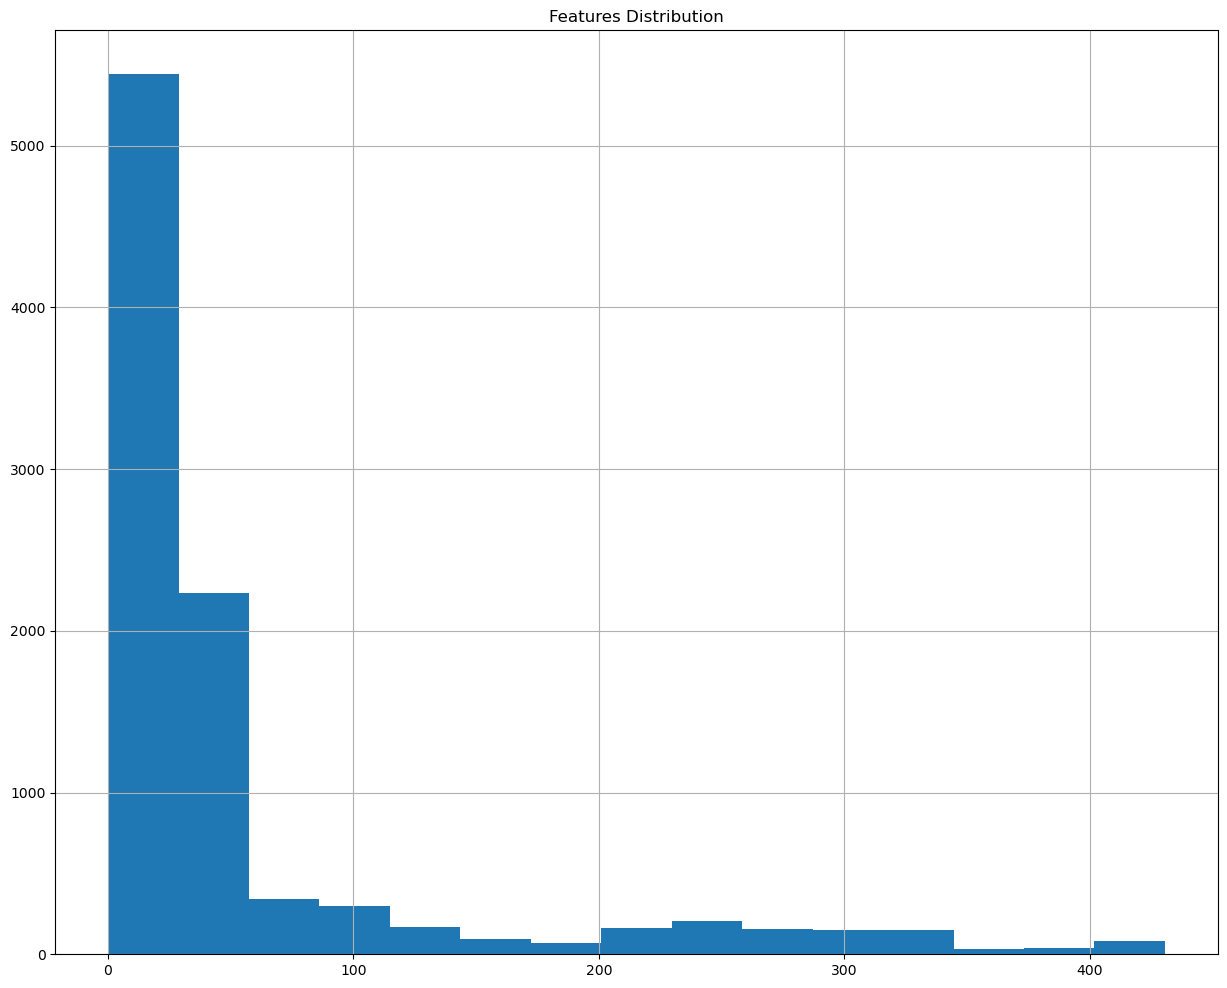

In [15]:
df.hist(figsize=(15,12),bins = 15)
plt.title("Features Distribution")
plt.show()

In [16]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


##  Train-Test split

In [18]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]
  

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

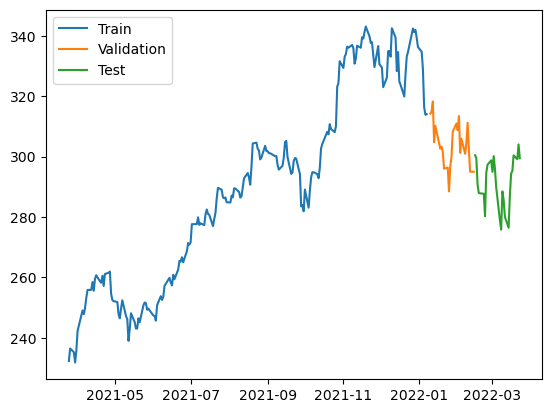

In [19]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

#  Model Building

In [20]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 83598.6250 - mean_absolute_error: 287.2760 - val_loss: 92416.2812 - val_mean_absolute_error: 303.9133
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 83483.5938 - mean_absolute_error: 287.2594 - val_loss: 92316.9219 - val_mean_absolute_error: 303.7498
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 83297.8438 - mean_absolute_error: 286.9593 - val_loss: 92188.5391 - val_mean_absolute_error: 303.5384
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 85041.2969 - mean_absolute_error: 289.8461 - val_loss: 91996.3984 - val_mean_absolute_error: 303.2217
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 83528.5312 - mean_absolute_error: 287.2840 - val_loss: 91738.7188 - val_mean_absolute_error: 302.7965
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 86403.9141 - mean_absolute_error: 292.1144 - val_loss: 91398.4766 - val_mean_absolute_error: 302.2342
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

## Model Testing

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


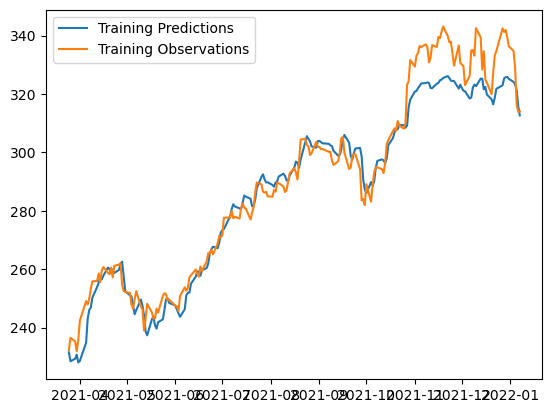

In [21]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


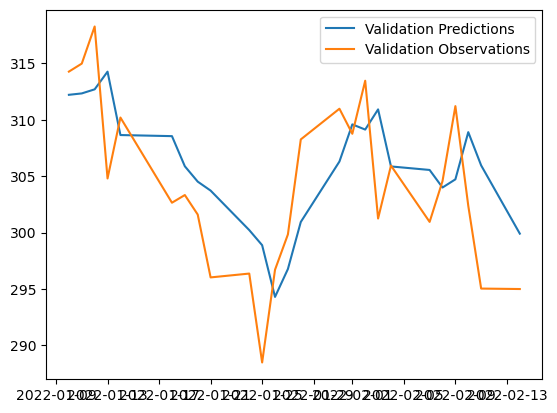

In [22]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


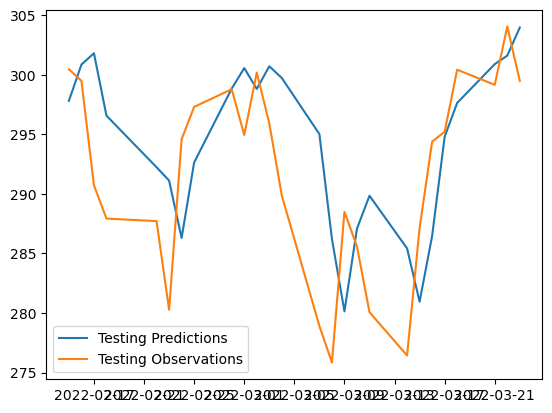

In [23]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

## Model Evaluation 

In [24]:


from sklearn.metrics import mean_absolute_error
val_mae = mean_absolute_error(y_val, val_predictions)
print(f"Validation MAE: {val_mae}")



test_mae = mean_absolute_error(y_test, test_predictions)
print(f"Test MAE: {test_mae}")


Validation MAE: 4.839194297790527
Test MAE: 5.957488059997559


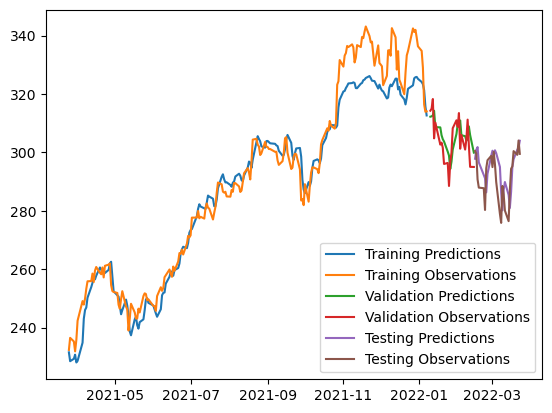

In [25]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

# Saving the model

In [44]:
save_model(model, 'stockforecasting.keras')

In [45]:
loaded_model = load_model('stockforecasting.keras')

C:\Users\neil6\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


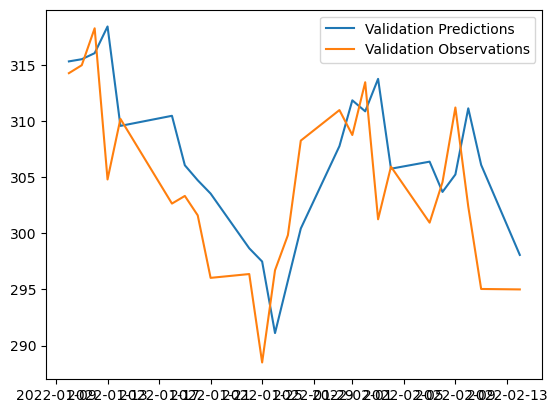

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


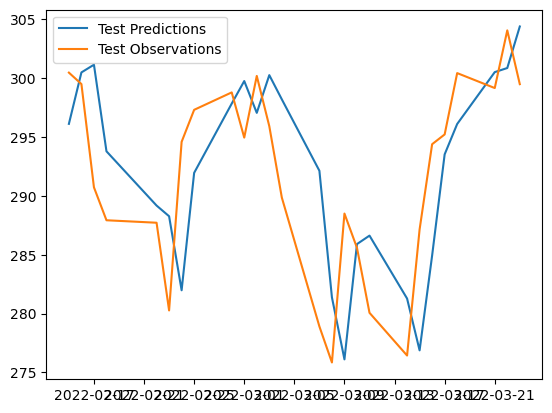

In [46]:

val_predictions =loaded_model.predict(X_val).flatten()


plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.show()


test_predictions =loaded_model.predict(X_test).flatten()


plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observations'])
plt.show()
